# Individualized Neural Tuning Model

In this Notebook, we will go through how to use the Individualized Neural Tuning (INT) model to model the responses of an individual with a shared functional template and individualized transforms.

## Preparations

In [1]:
%%capture
%pip install -U neuroboros

In [8]:
import numpy as np
import neuroboros as nb
from scipy.stats import zscore
from scipy.spatial.distance import pdist, cdist, squareform
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

from hyperalignment.procrustes import procrustes
from hyperalignment.ridge import ridge
from hyperalignment.local_template import compute_template

The Life dataset contains fMRI data (a) during watching the Life documentary and (b) during watching videos of various actions of various animals. See Nastase et al. ([2017](https://doi.org/10.1093/cercor/bhx138), [2018](https://doi.org/10.3389/fnins.2018.00316)) for more details.

This example focuses on the movie data (Life documentary).

In [3]:
dset = nb.Life()
sids = dset.subjects

## Region of interest (ROI)

Similar to the previous tutorial, we will use a searchlight from the ventral temporal cortex as the ROI.

The searchlight index is 4586 for the left hemisphere, and 5876 for the right hemisphere.

:::{image} vt_roi.png
:alt: VT ROI
:width: 500px
:align: center
:::


<div>
<img src="vt_roi.png" alt="VT ROI" style="width:500px;"/>
</div>

## Data folding

To properly test the generalizability of a model, it is critical to evaluate the performance of the model using data that's independent of the training data.
The *Life* dataset has 19 participants, and we will use the first 10 participants to build the template, and the remaining 9 participants to evaluate performance.

In [5]:
len(sids)

19

In [34]:
sls = nb.sls('r', 20)
roi = sls[5876]

dms12, dms34 = [], []
for sid in sids:
    dm = dset.get_data(sid, 'life', [1, 2], 'r')[:, roi]
    dms12.append(dm)
    dm = dset.get_data(sid, 'life', [3, 4], 'r')[:, roi]
    dms34.append(dm)

train = np.concatenate(
    [np.stack(dms12[:10], axis=0), np.stack(dms34[:10], axis=0)],
    axis=1)
test12 = np.stack(dms12[10:], axis=0)
test34 = np.stack(dms34[10:], axis=0)
print(train.shape, test12.shape, test34.shape)

(10, 1479, 122) (9, 704, 122) (9, 775, 122)


## Create functional template

Here we create the local functional template in the same way as the previous tutorial.

In [31]:
ns, nt, nv = train.shape
U, s, Vt = nb.linalg.safe_svd(
    train.transpose(1, 0, 2).reshape(nt, ns * nv))
pc_tpl = U[:, :nv] * s[np.newaxis, :nv]

RR = procrustes(
    np.concatenate([pc_tpl] * ns, axis=0),
    train.reshape(ns * nt, nv))
tpl = pc_tpl @ RR

print(tpl.shape)

(1479, 122)


## Stimulus matrix

We use the normalized PCs as the stimulus matrix $S$ in the INT model.
We normalize each PC to unit variance, so that the tuning matrix $T$ does not change with the number of time points of input data.

In [32]:
np.std(U, axis=0)

array([0.026, 0.026, 0.026, ..., 0.026, 0.026, 0.026])

In [41]:
S = U * np.sqrt(U.shape[0])
np.std(S, axis=0)

array([1., 1., 1., ..., 1., 1., 1.])

Note that usually $S$ is derived based on PCA of **all vertices of all participants**, and the number of features ($n_s \times n_v$) is far larger than the number of time points ($n_t$), so $U$ (and $S$) is a square matrix with full rank.

In this example, we used only vertices in the ROI, and $S$ is a singular matrix that is not invertible, so we used the pseudo-inverse (`np.linalg.pinv`) instead of the inverse (`np.linalg.inv`).

In [44]:
S_inv = np.linalg.pinv(S)

## Individualized neural tuning

By **aligning the template to each individual**, we derive the individualized transform for each individual (and each part of the movie).
These individualized transforms can be converted to individualized tuning matrices ($T$s).

In [58]:
Bhats12 = []
Ts12 = []
for dm in test12:
    W = ridge(tpl[:704], dm, 1e3)
    Bhat = tpl @ W
    Bhats12.append(Bhat)
    T = S_inv @ Bhat
    Ts12.append(T)
Ts12 = np.stack(Ts12)
print(Ts12.shape)

(9, 1220, 122)


In [59]:
Bhats34 = []
Ts34 = []
for dm in test34:
    W = ridge(tpl[704:], dm, 1e3)
    Bhat = tpl @ W
    Bhats34.append(Bhat)
    T = S_inv @ Bhat
    Ts34.append(T)
Ts34 = np.stack(Ts34)
print(Ts34.shape)

(9, 1220, 122)


In [60]:
Bhats12 = np.stack(Bhats12)
Bhats34 = np.stack(Bhats34)

## Cross-movie-part similarities

In the previous part, we obtained two estimates of the tuning matrix of each participant: one based on the first half of the movie (Runs 1 and 2), the other based on the other half of the movie (Runs 3 and 4).

Here we compute the similarity of tuning matrix estimates from different movie halves, that is between the 9 tuning matrix estimates based on the 1st half of the movie and the 9 tuning matrix estimates based on the 2nd half of the movie.

This generates a 9 × 9 similarity matrix, where the diagonal of the matrix are within-subject similarities.

See [Feilong et al. (2023)](https://doi.org/10.1162/imag_a_00032) for more details.

In [48]:
ns, k, nv = Ts12.shape
d_mat = cdist(Ts12.reshape(ns, -1), Ts34.reshape(ns, -1), 'correlation')
r_mat = 1 - d_mat

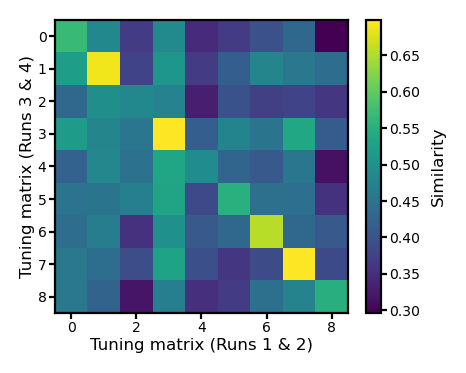

In [78]:
fig, ax = plt.subplots(1, 1, figsize=[_/2.54 for _ in [6, 6]], dpi=200)
im = ax.imshow(r_mat)
ax.tick_params('both', size=2, pad=1, labelsize=5)
ax.set_xlabel('Tuning matrix (Runs 1 & 2)', size=6, labelpad=1)
ax.set_ylabel('Tuning matrix (Runs 3 & 4)', size=6, labelpad=1)
bar = plt.colorbar(im, ax=ax, shrink=0.82, label='Similarity')
bar.ax.set_ylabel('Similarity', size=6)
bar.ax.tick_params('both', size=2, pad=1, labelsize=5)
plt.show()

## Normalize the similarity matrix

The similarity matrix based on a single ROI can be noisy.
If a tuning matrix estimate has low quality, it affects both within-subject similarity and betwen-subject similarities.
We normalize each row and each column to zero mean to emphasize the differences of within- and between-subject similarities.

In [56]:
r_mat2 = (r_mat
    - r_mat.mean(axis=0, keepdims=True)
    - r_mat.mean(axis=1, keepdims=True)
    + r_mat.mean())
np.testing.assert_allclose(r_mat2.sum(axis=0), 0, atol=1e-10)
np.testing.assert_allclose(r_mat2.sum(axis=1), 0, atol=1e-10)

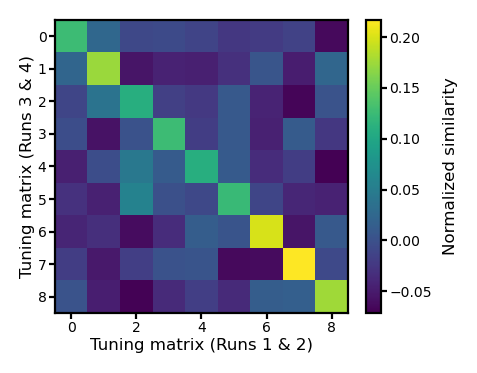

In [80]:
fig, ax = plt.subplots(1, 1, figsize=[_/2.54 for _ in [6, 6]], dpi=200)
im = ax.imshow(r_mat2)
ax.tick_params('both', size=2, pad=1, labelsize=5)
ax.set_xlabel('Tuning matrix (Runs 1 & 2)', size=6, labelpad=1)
ax.set_ylabel('Tuning matrix (Runs 3 & 4)', size=6, labelpad=1)
bar = plt.colorbar(im, ax=ax, shrink=0.82, label='Similarity')
bar.ax.set_ylabel('Normalized similarity', size=6)
bar.ax.tick_params('both', size=2, pad=1, labelsize=5)
plt.show()

Alternatively, we can use within-subject similarity as the reliability of the participant's tuning matrix estimates, and use the reliability to adjust the correlation values.

Based on classical test theory, the correlation between two variables $a$ and $b$ is their "true" correlation ($r_{a,b}^{\text{true}}$) attenuated based on the reliabilities of $a$ and $b$ ($\rho_a$ and $\rho_b$, respectively).

$$ r_{a,b} = r_{a,b}^{\text{true}} \sqrt{\rho_a \rho_b} $$

In [82]:
r_mat3 = r_mat / np.sqrt(np.diag(r_mat)) / np.sqrt(np.diag(r_mat))[np.newaxis]
np.testing.assert_allclose(np.diag(r_mat3), 1, atol=1e-10)

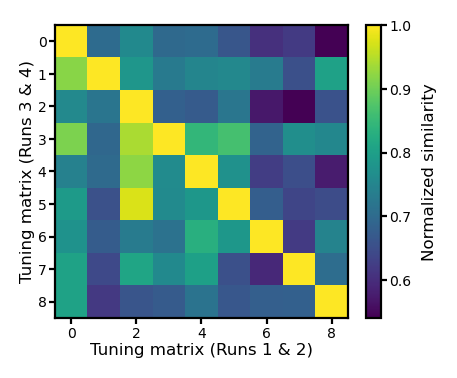

In [84]:
fig, ax = plt.subplots(1, 1, figsize=[_/2.54 for _ in [6, 6]], dpi=200)
im = ax.imshow(r_mat3)
ax.tick_params('both', size=2, pad=1, labelsize=5)
ax.set_xlabel('Tuning matrix (Runs 1 & 2)', size=6, labelpad=1)
ax.set_ylabel('Tuning matrix (Runs 3 & 4)', size=6, labelpad=1)
bar = plt.colorbar(im, ax=ax, shrink=0.82, label='Similarity')
bar.ax.set_ylabel('Normalized similarity', size=6)
bar.ax.tick_params('both', size=2, pad=1, labelsize=5)
plt.show()

## Movie time point/segment classification

In this example, we compare the predicted responses with the actual measured responses and try to predict which time point (or segment) of the movie the participant was watching.

We use data from the first part of the movie for testing (`test12`), and the estimated responses are based on the tuning matrix from the second part of the movie (`Ts12`). Therefore, the training and testing data are independent.

In [89]:
print(Bhats34.shape, test12.shape)

(9, 1479, 122) (9, 704, 122)


The estimation can be performed by multiplying the stimulus matrix $S$ of the first part of the movie (based on the training participants) with the tuning matrix $T$ of the test participant estimated from the second half of the movie.

Note that in the entire process, the test data (the test participant's responses to the first half of the movie) is not used.

In [115]:
pred12_ = np.stack([S[:704] @ _ for _ in Ts34])
print(pred12_.shape)

(9, 704, 122)


Because the template was built based on responses to the movie, we can also use the corresponding parts of $\hat{B}$ as the predicted responses.

In [116]:
pred12 = Bhats34[:, :704]
print(pred12.shape, test12.shape)

(9, 704, 122) (9, 704, 122)


These two estimates are equivalent.

In [118]:
np.testing.assert_allclose(pred12_, pred12)

We can use `scipy.spatial.distance.cdist` to compute a $n_t \times n_t$ matrix, where each element is the correlation distance between the spatial pattern of a time point in the measured data and the spatial pattern of a time point in the predicted data.

The multi-class classification is correct if the target time point has the smallest correlation distance among all time points.

In [121]:
d = cdist(test12[0], pred12[0], 'correlation')

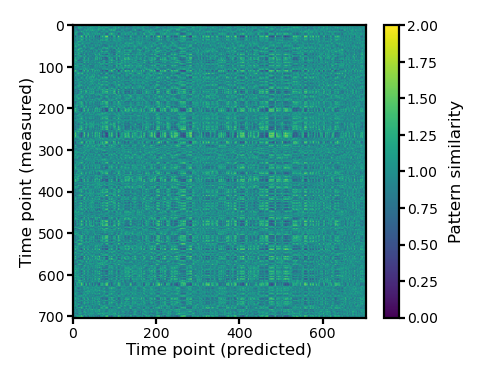

In [122]:
fig, ax = plt.subplots(1, 1, figsize=[_/2.54 for _ in [6, 6]], dpi=200)
im = ax.imshow(d, vmax=2, vmin=0)
ax.tick_params('both', size=2, pad=1, labelsize=5)
ax.set_xlabel('Time point (predicted)', size=6, labelpad=1)
ax.set_ylabel('Time point (measured)', size=6, labelpad=1)
bar = plt.colorbar(im, ax=ax, shrink=0.82)
bar.ax.set_ylabel('Pattern similarity', size=6)
bar.ax.tick_params('both', size=2, pad=1, labelsize=5)
plt.show()

In [92]:
ns, nt, nv = pred12.shape
acc = np.zeros((ns, ns))
for i in range(ns):
    for j in range(ns):
        dm = test12[i]
        pred = pred12[j]
        d = cdist(dm, pred, 'correlation')
        acc[i, j] = (np.arange(nt) == np.argmin(d, axis=1)).mean()

The classification accuracy based on the participant's own predicted patterns is higher than those based on other participants' predicted patterns.

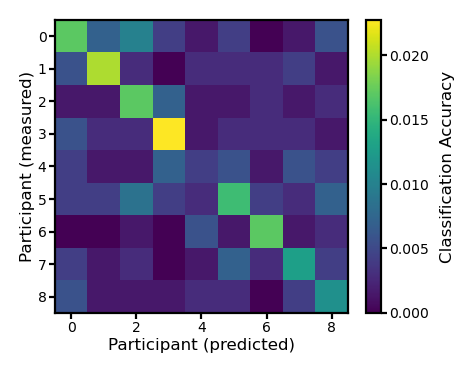

In [96]:
fig, ax = plt.subplots(1, 1, figsize=[_/2.54 for _ in [6, 6]], dpi=200)
im = ax.imshow(acc)
ax.tick_params('both', size=2, pad=1, labelsize=5)
ax.set_xlabel('Participant (predicted)', size=6, labelpad=1)
ax.set_ylabel('Participant (measured)', size=6, labelpad=1)
bar = plt.colorbar(im, ax=ax, shrink=0.82)
bar.ax.set_ylabel('Classification Accuracy', size=6)
bar.ax.tick_params('both', size=2, pad=1, labelsize=5)
plt.show()

## Movie segment classification

In [98]:
ns, nt, nv = pred12.shape
acc = np.zeros((ns, ns))
for i in range(ns):
    for j in range(ns):
        dm = test12[i][:700].reshape(70, -1)
        pred = pred12[j][:700].reshape(70, -1)
        d = cdist(dm, pred, 'correlation')
        acc[i, j] = (np.arange(nt//10) == np.argmin(d, axis=1)).mean()

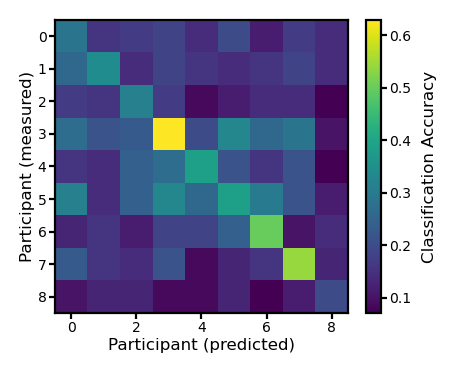

In [99]:
fig, ax = plt.subplots(1, 1, figsize=[_/2.54 for _ in [6, 6]], dpi=200)
im = ax.imshow(acc)
ax.tick_params('both', size=2, pad=1, labelsize=5)
ax.set_xlabel('Participant (predicted)', size=6, labelpad=1)
ax.set_ylabel('Participant (measured)', size=6, labelpad=1)
bar = plt.colorbar(im, ax=ax, shrink=0.82)
bar.ax.set_ylabel('Classification Accuracy', size=6)
bar.ax.tick_params('both', size=2, pad=1, labelsize=5)
plt.show()

## Binary classification

In [104]:
ns, nt, nv = pred12.shape
acc = np.zeros((ns, ns))
for i in range(ns):
    for j in range(ns):
        dm = test12[i]
        pred = pred12[j]
        d = cdist(dm, pred, 'correlation')
        a = (np.diag(d)[:,np.newaxis] < d).sum(axis=1) / (nt - 1)
        acc[i, j] = a.mean()

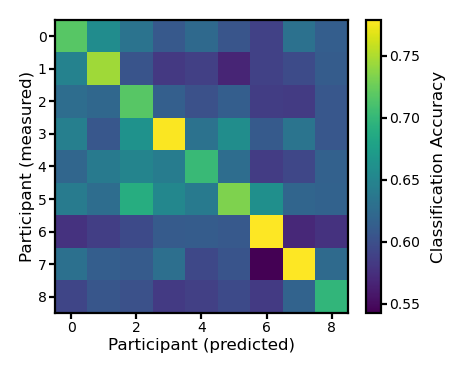

In [105]:
fig, ax = plt.subplots(1, 1, figsize=[_/2.54 for _ in [6, 6]], dpi=200)
im = ax.imshow(acc)
ax.tick_params('both', size=2, pad=1, labelsize=5)
ax.set_xlabel('Participant (predicted)', size=6, labelpad=1)
ax.set_ylabel('Participant (measured)', size=6, labelpad=1)
bar = plt.colorbar(im, ax=ax, shrink=0.82)
bar.ax.set_ylabel('Classification Accuracy', size=6)
bar.ax.tick_params('both', size=2, pad=1, labelsize=5)
plt.show()

Note that the code above does not handle special cases where the correlation distances with the two predicted patterns are identical.
In this case, it does not make sense to label the classification as accurate (1.0) or inaccurate (0.0).
It might be better to mark the accuracy for this pair of patterns as 0.5.
This can be done by rewrite the comparison `np.diag(d)[:,np.newaxis] < d` using `np.sign(np.diag(d)[:,np.newaxis] - d)`, and the accuracy can be computed as `(sign + 1) * 0.5`.